## Assembly to order
### Deterministic model

In [1]:
# import library
import gurobipy as gp 
from gurobipy import GRB 
import pandas as pd
# import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np
import csv, json 

In [2]:
# Load data

df1 = pd.read_csv('../data/components_data.csv', index_col=0)
with open('../data/products_machines.csv', 'r') as f:
    reader = csv.reader(f)
    num_items, num_machines = next(reader)
    num_items = int(num_items)
    num_machines = int(num_machines)
    products_price = {}
    for i in range(num_items):
        p, s = next(reader)
        products_price[p] = int(s)
    machine_daily_time = {}
    for i in range(num_machines):
        m, t = next(reader)
        machine_daily_time[m] = int(t)
num_components = len(df1)
products = list(products_price.keys())


In [3]:
df1

,Wave Soldering Machine,Assembly Robot,Pick-and-Place Machine,Test Bench,Presses and Case Molding Machine,Laser or Plasma Cutting Machine,Burn-in Machine (Stress Testing),Packaging Machine,Computer_A,Computer_B,price
Central Processing Unit (CPU),0,6.0,2,3,0,0,6,0.02,1,1,150
Graphics Processing Unit (GPU) Intel,0,7.0,2,3,0,0,6,0.02,0,1,240
Graphics Processing Unit (GPU) NVIDIA,0,10.0,3,3,0,0,6,0.02,1,0,320
Motherboard,20,3.0,8,3,0,0,6,0.02,1,1,30
Random Access Memory (RAM) 16GB,0,2.0,2,3,0,0,6,0.02,0,1,30
Random Access Memory (RAM) 32GB,0,2.0,2,3,0,0,6,0.02,1,0,50
Storage Drive SSD 1TB,0,5.0,6,3,0,0,6,0.02,1,0,60
Storage Drive SSD 512GB,0,3.0,2,3,0,0,6,0.02,0,1,40
Storage Drive Hard Disk Drive,0,1.0,1,3,0,0,6,0.02,0,1,25
Battery,0,2.0,2,3,0,0,6,0.02,1,1,20


In [4]:
products_price, machine_daily_time

({'Computer_A': 1800, 'Computer_B': 1600},
 {'Wave Soldering Machine': 2880,
  'Assembly Robot': 2880,
  'Pick-and-Place Machine': 4320,
  'Test Bench': 3840,
  'Presses and Case Molding Machine': 960,
  'Laser or Plasma Cutting Machine': 2880,
  'Burn-in Machine (Stress Testing)': 7200,
  'Packaging Machine': 1440})

In [5]:
# Print the components for each product and their price

pri = df1.loc[:,products].map(lambda x: 'Yes' if x > 0 else '')
pri['price'] = df1['price']
pri

,Computer_A,Computer_B,price
Central Processing Unit (CPU),Yes,Yes,150
Graphics Processing Unit (GPU) Intel,,Yes,240
Graphics Processing Unit (GPU) NVIDIA,Yes,,320
Motherboard,Yes,Yes,30
Random Access Memory (RAM) 16GB,,Yes,30
Random Access Memory (RAM) 32GB,Yes,,50
Storage Drive SSD 1TB,Yes,,60
Storage Drive SSD 512GB,,Yes,40
Storage Drive Hard Disk Drive,,Yes,25
Battery,Yes,Yes,20


In [6]:
# Time to produce the first product for each machine

df1[df1[products[0]]==1].iloc[:,:num_machines].sum(axis=0)

Wave Soldering Machine               52.0
Assembly Robot                       52.9
Pick-and-Place Machine               74.0
Test Bench                           75.0
Presses and Case Molding Machine     20.0
Laser or Plasma Cutting Machine      75.0
Burn-in Machine (Stress Testing)    150.0
Packaging Machine                     0.5
dtype: float64

In [7]:
# Time to produce the second product for each machine

df1[df1[products[1]]==1].iloc[:,:num_machines].sum(axis=0)

Wave Soldering Machine               57.00
Assembly Robot                       46.40
Pick-and-Place Machine               65.00
Test Bench                           78.00
Presses and Case Molding Machine     20.00
Laser or Plasma Cutting Machine      70.00
Burn-in Machine (Stress Testing)    156.00
Packaging Machine                     0.52
dtype: float64

In [8]:
print(f"The total cost of the components for the first product is {sum(df1[products[0]]*df1['price'])} €")
print(f"The total cost of the components for the second product is {sum(df1[products[1]]*df1['price'])} €")

The total cost of the components for the first product is 925 €
The total cost of the components for the second product is 799 €


In [9]:
component_time = df1.iloc[:,:num_machines].sum(axis=1)
print(f"The total time for manifacturing the first product is {round(sum(df1[products[0]]*component_time),2)} minutes")
print(f"The total time for manifacturing for the second product is {round(sum(df1[products[1]]*component_time),2)} minutes")

The total time for manifacturing the first product is 499.4 minutes
The total time for manifacturing for the second product is 492.92 minutes


In [10]:
print(f'The selling price of the first product is {products_price[products[0]]} €')
print(f'The selling price of the second product is {products_price[products[1]]} €')

The selling price of the first product is 1800 €
The selling price of the second product is 1600 €


In [11]:
# Set the demand for each product

demand = [130, 85]

In [12]:
## DETERMINISTIC MODEL

model = gp.Model("ato")

## Decision variables
# y[j] is the amount of product j produced
y = model.addVars(num_items, vtype=GRB.INTEGER, name="y")

# x[i] is the number of i components 
x = model.addVars(num_components, vtype=GRB.INTEGER, name="x")

# Objective function: maximaze the profit (revenue from the sells of computer - costs of th components)
model.setObjective(
    - gp.quicksum(df1.iloc[i,-1] * x[i] for i in range(num_components)) +
    gp.quicksum(products_price[products[j]] * y[j] for j in range(num_items)),
    GRB.MAXIMIZE
)

# Constraint 1: the amount of hours of work for every piece must be inferior to the threshold for the machines
model.addConstrs(
    (gp.quicksum(df1.iloc[i,j] * x[i] for i in range(num_components)) <= machine_daily_time[list(machine_daily_time.keys())[j]]*5 for j in range(num_machines)),
    name="working_hours"
)

# Constraint 2: the number of products of every type must be fewer the demand
model.addConstrs(
    (y[j] <= demand[j] for j in range(num_items)),
    name="qty_products"
)

# Constraint 3: gozinto factor
model.addConstrs(
    (gp.quicksum(df1.iloc[i,j+num_machines] * y[j] for j in range(num_items)) <= x[i] for i in range(num_components)),
    name="gozinto"
)

## Optimize the model
model.optimize()

## Output solution details
if model.status == GRB.OPTIMAL:
    print(' ')
    print("Optimal Solution Found:")
    
    for j in range(num_items):
            print(f"{y[j].x} units of {products[j]}")


Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 23.3.0 23D56)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 43 rows, 35 columns and 267 nonzeros
Model fingerprint: 0x8d07a4d3
Variable types: 0 continuous, 35 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-02, 3e+01]
  Objective range  [2e+00, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+01, 4e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 41 rows and 32 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 5 nonzeros
Variable types: 0 continuous, 3 integer (0 binary)

Root relaxation: objective 1.669593e+05, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

 

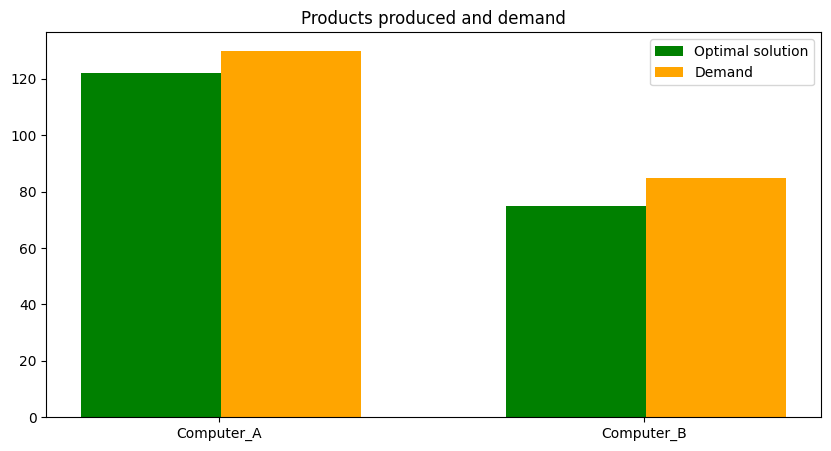

In [13]:
plt.figure(figsize=(10, 5))
width = 0.33
xx = np.arange(num_items)
plt.bar(xx, [y[j].x for j in range(num_items)], width, label='Optimal solution',color='g')
plt.bar(xx+width, demand, width, label='Demand', color='orange')
#plt.bar(x+0.5,[demand[j]-y[j].x for j in range(num_items)], width, label='Unsatisfied demand')
plt.xticks(xx+0.16, products)
plt.legend()
plt.title('Products produced and demand')
plt.show()

In [14]:
print(f'The total profit is {model.objVal} €')
print('It is composed by:') 
print(f' {products_price[products[0]] * y[0].x } € from the sells of {products[0]}')
print(f' {products_price[products[1]] * y[1].x } € from the sells of {products[1]}')
print(f' - {sum(df1.iloc[i,-1] * x[i].x for i in range(num_components))} € from the cost of the components')


The total profit is 166825.0 €
It is composed by:
 219600.0 € from the sells of Computer_A
 120000.0 € from the sells of Computer_B
 - 172775.0 € from the cost of the components
